---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Haoran Guo
date: "2025-04-10"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 00:03:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: date (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: date (nullable = true)
 |-- EXPIRED: date (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: date (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS

25/04/11 00:03:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+--------------------+-----------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+---

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
#| eval: false
#| echo: true

from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df_clean = df.select(
    "SALARY", 
    "MIN_YEARS_EXPERIENCE", 
    "MIN_EDULEVELS", 
    "NAICS2_NAME"
).dropna()

categorical_cols = ["NAICS2_NAME"]
numerical_cols = ["MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df_clean)
df_prepared = pipeline_model.transform(df_clean)

df_prepared.select("SALARY", "features").show(5, truncate=False)

+------+---------------------------+
|SALARY|features                   |
+------+---------------------------+
|92962 |(21,[0,1,2],[2.0,2.0,1.0]) |
|107645|(21,[0,9],[10.0,1.0])      |
|192800|(21,[0,1,2],[6.0,2.0,1.0]) |
|125900|(21,[0,1,2],[12.0,1.0,1.0])|
|170000|(21,[0,1,5],[6.0,99.0,1.0])|
+------+---------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
#| eval: true
#| echo: false

train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=517)

print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(1883, 7)


[Stage 10:>                                                         (0 + 1) / 1]

(430, 7)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [6]:
df_pandas = df_prepared.select("SALARY", "MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS", "NAICS2_NAME").toPandas()

In [7]:
df_pandas = df_pandas.dropna()
df_dummies = pd.get_dummies(df_pandas, columns=["NAICS2_NAME"], drop_first=True)

In [8]:
import statsmodels.api as sm
import pandas as pd

y = df_dummies["SALARY"]
X = df_dummies.drop("SALARY", axis=1)
X = sm.add_constant(X)
X = X.astype(float)
y = y.astype(float)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     50.37
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          2.64e-171
Time:                        23:40:40   Log-Likelihood:                -27506.
No. Observations:                2313   AIC:                         5.506e+04
Df Residuals:                    2291   BIC:                         5.518e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [9]:
results_df = pd.DataFrame({
    "Feature": model.params.index,
    "Estimate": model.params.values,
    "StdError": model.bse,
    "tValue": model.tvalues,
    "pValue": model.pvalues
})

results_df = results_df.round(4)
display(results_df)

,Feature,Estimate,StdError,tValue,pValue
const,const,119784.2340,7526.7104,15.9146,0.0000
MIN_YEARS_EXPERIENCE,MIN_YEARS_EXPERIENCE,5539.1246,236.7564,23.3959,0.0000
MIN_EDULEVELS,MIN_EDULEVELS,76.9493,22.3756,3.4390,0.0006
NAICS2_NAME_Administrative and Support and Waste Management and Remediation Services,NAICS2_NAME_Administrative and Support and Was...,-42529.2826,7753.6464,-5.4851,0.0000
"NAICS2_NAME_Agriculture, Forestry, Fishing and Hunting","NAICS2_NAME_Agriculture, Forestry, Fishing and...",46670.6211,36300.3694,1.2857,0.1987
NAICS2_NAME_Construction,NAICS2_NAME_Construction,-8003.4671,10071.1805,-0.7947,0.4269
NAICS2_NAME_Educational Services,NAICS2_NAME_Educational Services,-57404.3528,8566.9558,-6.7007,0.0000
NAICS2_NAME_Finance and Insurance,NAICS2_NAME_Finance and Insurance,-32077.2053,7694.1167,-4.1691,0.0000
NAICS2_NAME_Health Care and Social Assistance,NAICS2_NAME_Health Care and Social Assistance,-39032.9086,8333.3251,-4.6840,0.0000
NAICS2_NAME_Information,NAICS2_NAME_Information,-11730.7794,7842.9976,-1.4957,0.1349


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [6]:
#| eval: true
#| echo: false
import statsmodels.api as sm
df_pandas = df_prepared.select("SALARY", "MIN_YEARS_EXPERIENCE", "MIN_EDULEVELS", "NAICS2_NAME").toPandas()
df_pandas = df_pandas.dropna()
df_dummies = pd.get_dummies(df_pandas, columns=["NAICS2_NAME"], drop_first=True)
y = df_dummies["SALARY"]
X = df_dummies.drop("SALARY", axis=1)
X = sm.add_constant(X)
X = X.astype(float)
y = y.astype(float)
model = sm.OLS(y, X).fit()

coefs = model.params.values
se = model.bse.values
tvals = model.tvalues.values
pvals = model.pvalues.values

print("Length of features:", len(coefs))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

[Stage 14:>                                                         (0 + 1) / 1]

Length of features: 22
Length of coefs: 22
Length of se: 22
Length of tvals: 22
Length of pvals: 22


In [7]:
print(model.summary())
results_df = pd.DataFrame({
    "Feature": model.params.index,
    "Estimate": model.params.values,
    "StdError": model.bse,
    "tValue": model.tvalues,
    "pValue": model.pvalues
})

results_df = results_df.round(4)
display(results_df)

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     50.37
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          2.64e-171
Time:                        00:06:00   Log-Likelihood:                -27506.
No. Observations:                2313   AIC:                         5.506e+04
Df Residuals:                    2291   BIC:                         5.518e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

,Feature,Estimate,StdError,tValue,pValue
const,const,119784.2340,7526.7104,15.9146,0.0000
MIN_YEARS_EXPERIENCE,MIN_YEARS_EXPERIENCE,5539.1246,236.7564,23.3959,0.0000
MIN_EDULEVELS,MIN_EDULEVELS,76.9493,22.3756,3.4390,0.0006
NAICS2_NAME_Administrative and Support and Waste Management and Remediation Services,NAICS2_NAME_Administrative and Support and Was...,-42529.2826,7753.6464,-5.4851,0.0000
"NAICS2_NAME_Agriculture, Forestry, Fishing and Hunting","NAICS2_NAME_Agriculture, Forestry, Fishing and...",46670.6211,36300.3694,1.2857,0.1987
NAICS2_NAME_Construction,NAICS2_NAME_Construction,-8003.4671,10071.1805,-0.7947,0.4269
NAICS2_NAME_Educational Services,NAICS2_NAME_Educational Services,-57404.3528,8566.9558,-6.7007,0.0000
NAICS2_NAME_Finance and Insurance,NAICS2_NAME_Finance and Insurance,-32077.2053,7694.1167,-4.1691,0.0000
NAICS2_NAME_Health Care and Social Assistance,NAICS2_NAME_Health Care and Social Assistance,-39032.9086,8333.3251,-4.6840,0.0000
NAICS2_NAME_Information,NAICS2_NAME_Information,-11730.7794,7842.9976,-1.4957,0.1349


The R-square indicates that approximately 31.6% of the variance in salary can be explained by the model and F-statiatic shows the overall model is statistically significant.MIN_YEARS_EXPERIENCE has a positive and significant coefficient, suggesting that each additional year of minimum required experience is associated with a ~$5,539 increase in salary. MIN_EDULEVELS is also positive and significant, indicating a marginal increase in salary for each unit increase in education level code. Industry category has significant effects on salary levels. Certain industries pay significantly less than the baseline even after controlling for experience and education.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


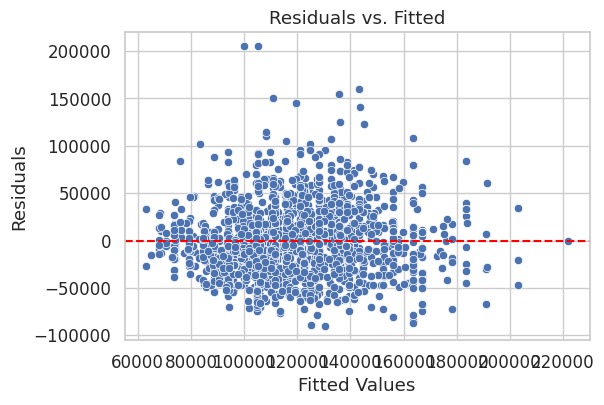

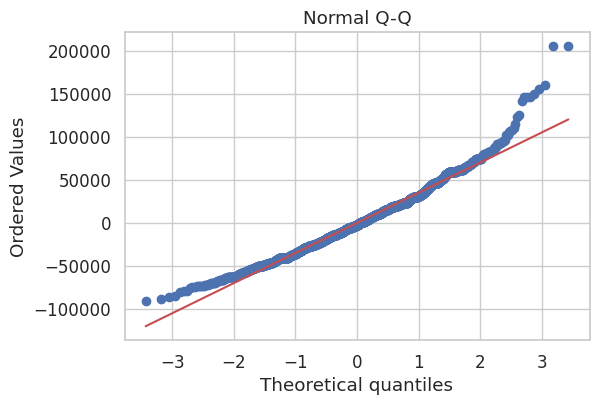

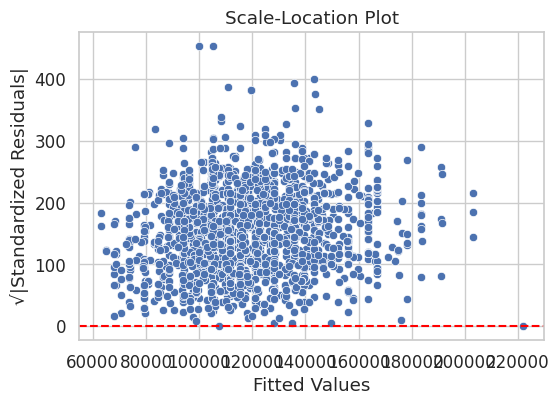

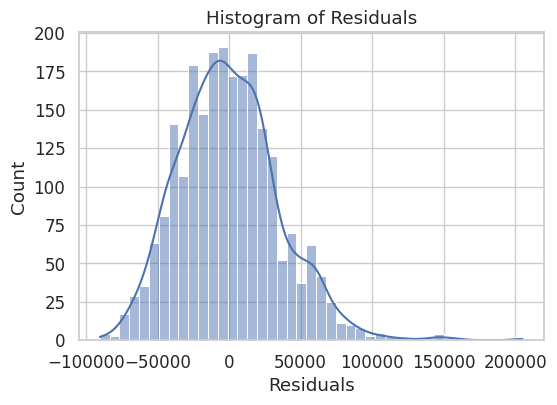

In [8]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = model.predict(X)
residuals = y - y_pred

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

import scipy.stats as stats

plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")
plt.title("Scale-Location Plot")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [14]:
#| eval: true
#| echo: false
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X)

# Evaluation metrics
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 27619.88
Mean Squared Error (MSE): 1249769670.63
Root Mean Squared Error (RMSE): 35352.08
R² Score: 0.3159


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

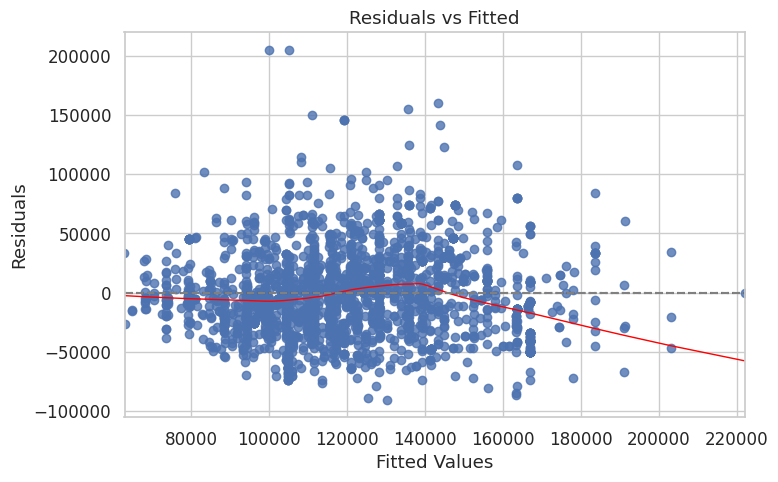

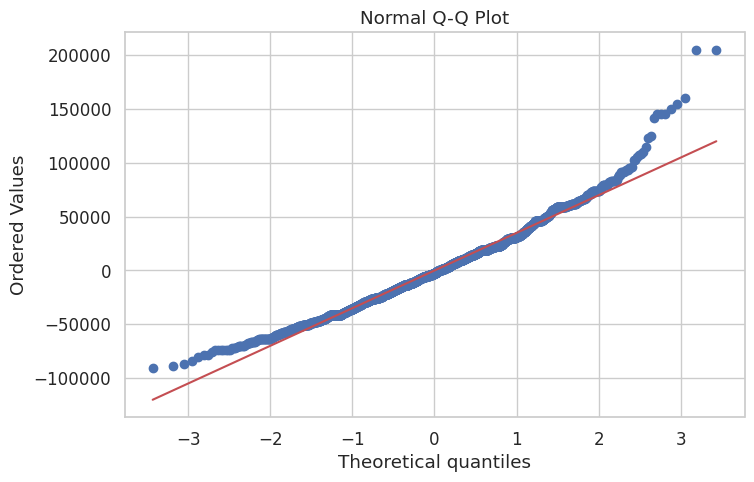

In [15]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

plt.figure(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

The first plot assesses the linear regression model’s assumption of homoscedasticity. The red smoothing line indicates a slight curve, and the spread of residuals increases as fitted values grow, suggesting heteroscedasticity and the model struggles to predict salary accurately at higher values.
The Q-Q plot compares the distribution of residuals to a normal distribution.The points largely follow the reference line in the middle suggests that while most residuals are normally distributed, extreme values do not conform to normality. 

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
